In [2]:
import pandas as pd
import os
import glob

df = pd.DataFrame()

In [3]:
dir = '/Users/harsha/Downloads/Netscribes/HDFC/1 Year Data/3Months'
file_list = glob.glob(os.path.join(dir, '*.xlsx'))
file_list

['/Users/harsha/Downloads/Netscribes/HDFC/1 Year Data/3Months/Master Log - Apr 2020.xlsx',
 '/Users/harsha/Downloads/Netscribes/HDFC/1 Year Data/3Months/Master Log - Jun 2020.xlsx',
 '/Users/harsha/Downloads/Netscribes/HDFC/1 Year Data/3Months/Master Log - May 2020.xlsx']

In [4]:
df = pd.concat((pd.read_excel(f) for f in file_list), ignore_index=True)

In [19]:
import datetime
df['day'] = (((df['Published Date'].dt.dayofweek).to_frame())['Published Date'])
df['month'] = pd.DatetimeIndex(df['Published Date']).month
# df['month_day'] = df['month'].astype(str)+'-'+df['day'].astype(str)
df['day_date'] = pd.DatetimeIndex(df['Published Date']).day

In [26]:
df['Snippet'] = df['Snippet'].astype(str)
df_group = df.groupby(by = ['Ticket ID','Product','Key Message','Aspects / Explaination / Root Cause Analysis'
                            ,'Source Type','day_date'])['Snippet'].apply(' '.join).reset_index()

In [27]:
df_group = df_group[pd.notnull(df_group['Snippet'])]
print('Final Text Count from',df.shape[0], 'is', str(df_group.shape[0]))

Final Text Count from 470997 is 254834


In [28]:
df_group['category_id'] = df_group['Product'].factorize()[0]
from io import StringIO
category_id_df = df_group[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

print(len(category_to_id))

20


                     Product  Snippet
2              Brand Mention   108977
5                Credit Card    67033
8                       Loan    14724
9              Market Update    11934
19           Savings Account    10557
1             Branch Banking     7924
13             MobileBanking     5613
15                       ORM     5578
7                 Debit Card     5358
10                 Marketing     4895
3      Consumer Durable Loan     2458
14                NetBanking     2358
17  Phone Banking - Non Card     1721
4        Corporate Practices     1234
18              Prepaid Card     1083
16      Phone Banking - Card     1055
0                        ATM      781
6            Current Account      732
11          Merchant Service      449
12            Millennia Card      370


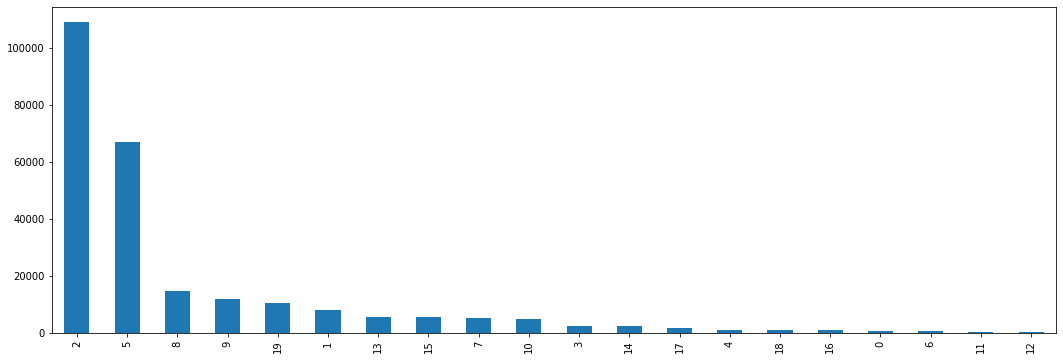

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,6))
grouped = df_group.groupby('Product').Snippet.count().reset_index()
grouped = grouped.sort_values('Snippet', ascending=False)
print((grouped))
grouped['Snippet'].plot.bar(ylim=0)
plt.show()

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df_group.Snippet).toarray()
labels = df_group.category_id
features.shape

(254834, 123183)

In [31]:
import re
from nltk.corpus import stopwords

print(df_group['Snippet'][:100])
df_group = df_group.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = re.sub(r"\s*\b(?:{})\b".format("|".join(STOPWORDS)), "", text)
    return re.sub(r" {2,}", " ", text.strip())

df_group['Snippet'] = df_group['Snippet'].apply(clean_text)
df_group['Snippet'] = df_group['Snippet'].str.replace('\d+', '')

0     @Cleartrip My flight is cancelled by the airli...
1     HDFC is a bank.  Echu Dee Eff See is a very Ta...
2     Prices start at Rs 41,999. Extra 2K off with H...
3     @HDFCBank_Cares @HDFC_Bank I am unable to get ...
4           Hi team Is there someone available for help
                            ...                        
95    @HDFC_Bank it's been almost 2 months ur bank i...
96                         Hello cannyou@please respond
97    I have send you all thing which you require , ...
98               Can you resolve a simple things please
99    @HDFC_Bank @HDFCBank_Cares @nsitharaman @RBI  ...
Name: Snippet, Length: 100, dtype: object


In [32]:
print(df_group['Snippet'][:100])

0     cleartrip myflight cancelled airline would lik...
1     hdfc bank echu dee eff see tamilian emotion#th...
2     prices start rs   extra k hdfc cards theres on...
3     hdfcbank_cares hdfc_bank unable get anyone end...
4                        hi team someone available help
                            ...                        
95    hdfc_bank almost  months ur bank msging abt re...
96                         hello cannyou please respond
97                send thing require action since  days
98                         resolve simple things please
99    hdfc_bank hdfcbank_cares nsitharaman rbi sent ...
Name: Snippet, Length: 100, dtype: object


In [121]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_group['Snippet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 209095 unique tokens.


In [122]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df_group['Snippet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (254834, 100)


In [123]:
df_sd = df_group[['Source Type','day_date']]
df_sd["Source Type"] = pd.Categorical(df_sd['Source Type'])
df_sd['Source Type'] = df_sd['Source Type'].cat.codes
print(df_sd)

        Source Type  day_date
0                 8         2
1                 8        20
2                 8        11
3                 9         7
4                 1         3
...             ...       ...
254829            2        30
254830            1        30
254831            8        30
254832            9        30
254833            1        30

[254834 rows x 2 columns]


/Users/harsha/Downloads/Programs/python_venv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/harsha/Downloads/Programs/python_venv3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [124]:
df_sd = df_sd.astype('int32')
print(df_sd.values)

[[ 8  2]
 [ 8 20]
 [ 8 11]
 ...
 [ 8 30]
 [ 9 30]
 [ 1 30]]


In [125]:
import numpy as np
X = np.concatenate([X, df_sd.values], 1)

In [126]:
Y = pd.get_dummies(df_group['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (254834, 20)


In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(229350, 102) (229350, 20)
(25484, 102) (25484, 20)


In [128]:
from keras.models import Sequential
from keras.layers import (
    Embedding,
    Conv1D,
    Dense,
    MaxPooling1D,
    AveragePooling1D,
    Flatten,
    GlobalAveragePooling1D,
    Dropout,
    SpatialDropout1D,
    LSTM,
)
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [129]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 206415 samples, validate on 22935 samples
Epoch 1/5
206415/206415 [==============================] - 393s 2ms/step - loss: 1.2327 - accuracy: 0.6271 - val_loss: 1.0225 - val_accuracy: 0.6789
Epoch 2/5
206415/206415 [==============================] - 369s 2ms/step - loss: 0.9777 - accuracy: 0.6922 - val_loss: 0.9700 - val_accuracy: 0.6933
Epoch 3/5
206415/206415 [==============================] - 379s 2ms/step - loss: 0.9019 - accuracy: 0.7134 - val_loss: 0.9601 - val_accuracy: 0.6955
Epoch 4/5
206415/206415 [==============================] - 370s 2ms/step - loss: 0.8463 - accuracy: 0.7282 - val_loss: 0.9694 - val_accuracy: 0.6915
Epoch 5/5
206415/206415 [==============================] - 364s 2ms/step - loss: 0.8025 - accuracy: 0.7409 - val_loss: 0.9862 - val_accuracy: 0.6955


In [130]:
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

25484/25484 [==============================] - 10s 378us/step
Test set
  Loss: 1.007
  Accuracy: 0.688


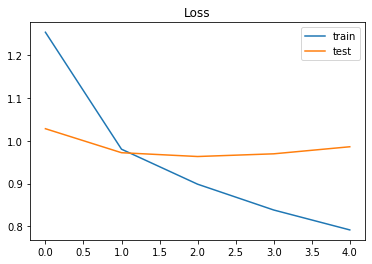

In [111]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [117]:
from keras.models import model_from_json
# serialize model to JSON
# model_json = model.to_json()
# with open("/Users/harsha/Downloads/Netscribes/HDFC/lstm_l1_source_date_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("/Users/harsha/Downloads/Netscribes/HDFC/lstm_l1_source_date_model.h5")
# print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('/Users/harsha/Downloads/Netscribes/HDFC/lstm_l1_source_date_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/harsha/Downloads/Netscribes/HDFC/lstm_l1_source_date_model.h5")
print("Loaded model from disk")
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk


In [112]:
category_id_df.columns = ['product_data', 'category_id']
category_id_df.product_data.values

array(['Marketing', 'Brand Mention', 'Credit Card', 'Loan',
       'MobileBanking', 'Current Account', 'Market Update',
       'Phone Banking - Card', 'Savings Account', 'Debit Card',
       'NetBanking', 'Branch Banking', 'ORM', 'Consumer Durable Loan',
       'Corporate Practices', 'Merchant Service',
       'Phone Banking - Non Card', 'Prepaid Card', 'Millennia Card',
       'ATM'], dtype=object)

In [113]:
y_pred = loaded_model.predict(X_test)

In [114]:
import numpy as np
Y_pred_1 = np.argmax(y_pred, axis=1)

Y_test_1 = np.argmax(Y_test, axis=1)
print(Y_test_1)

[5 2 5 ... 5 1 7]


In [115]:
aspect_list = (pd.get_dummies(df_group['Product'])).columns.values

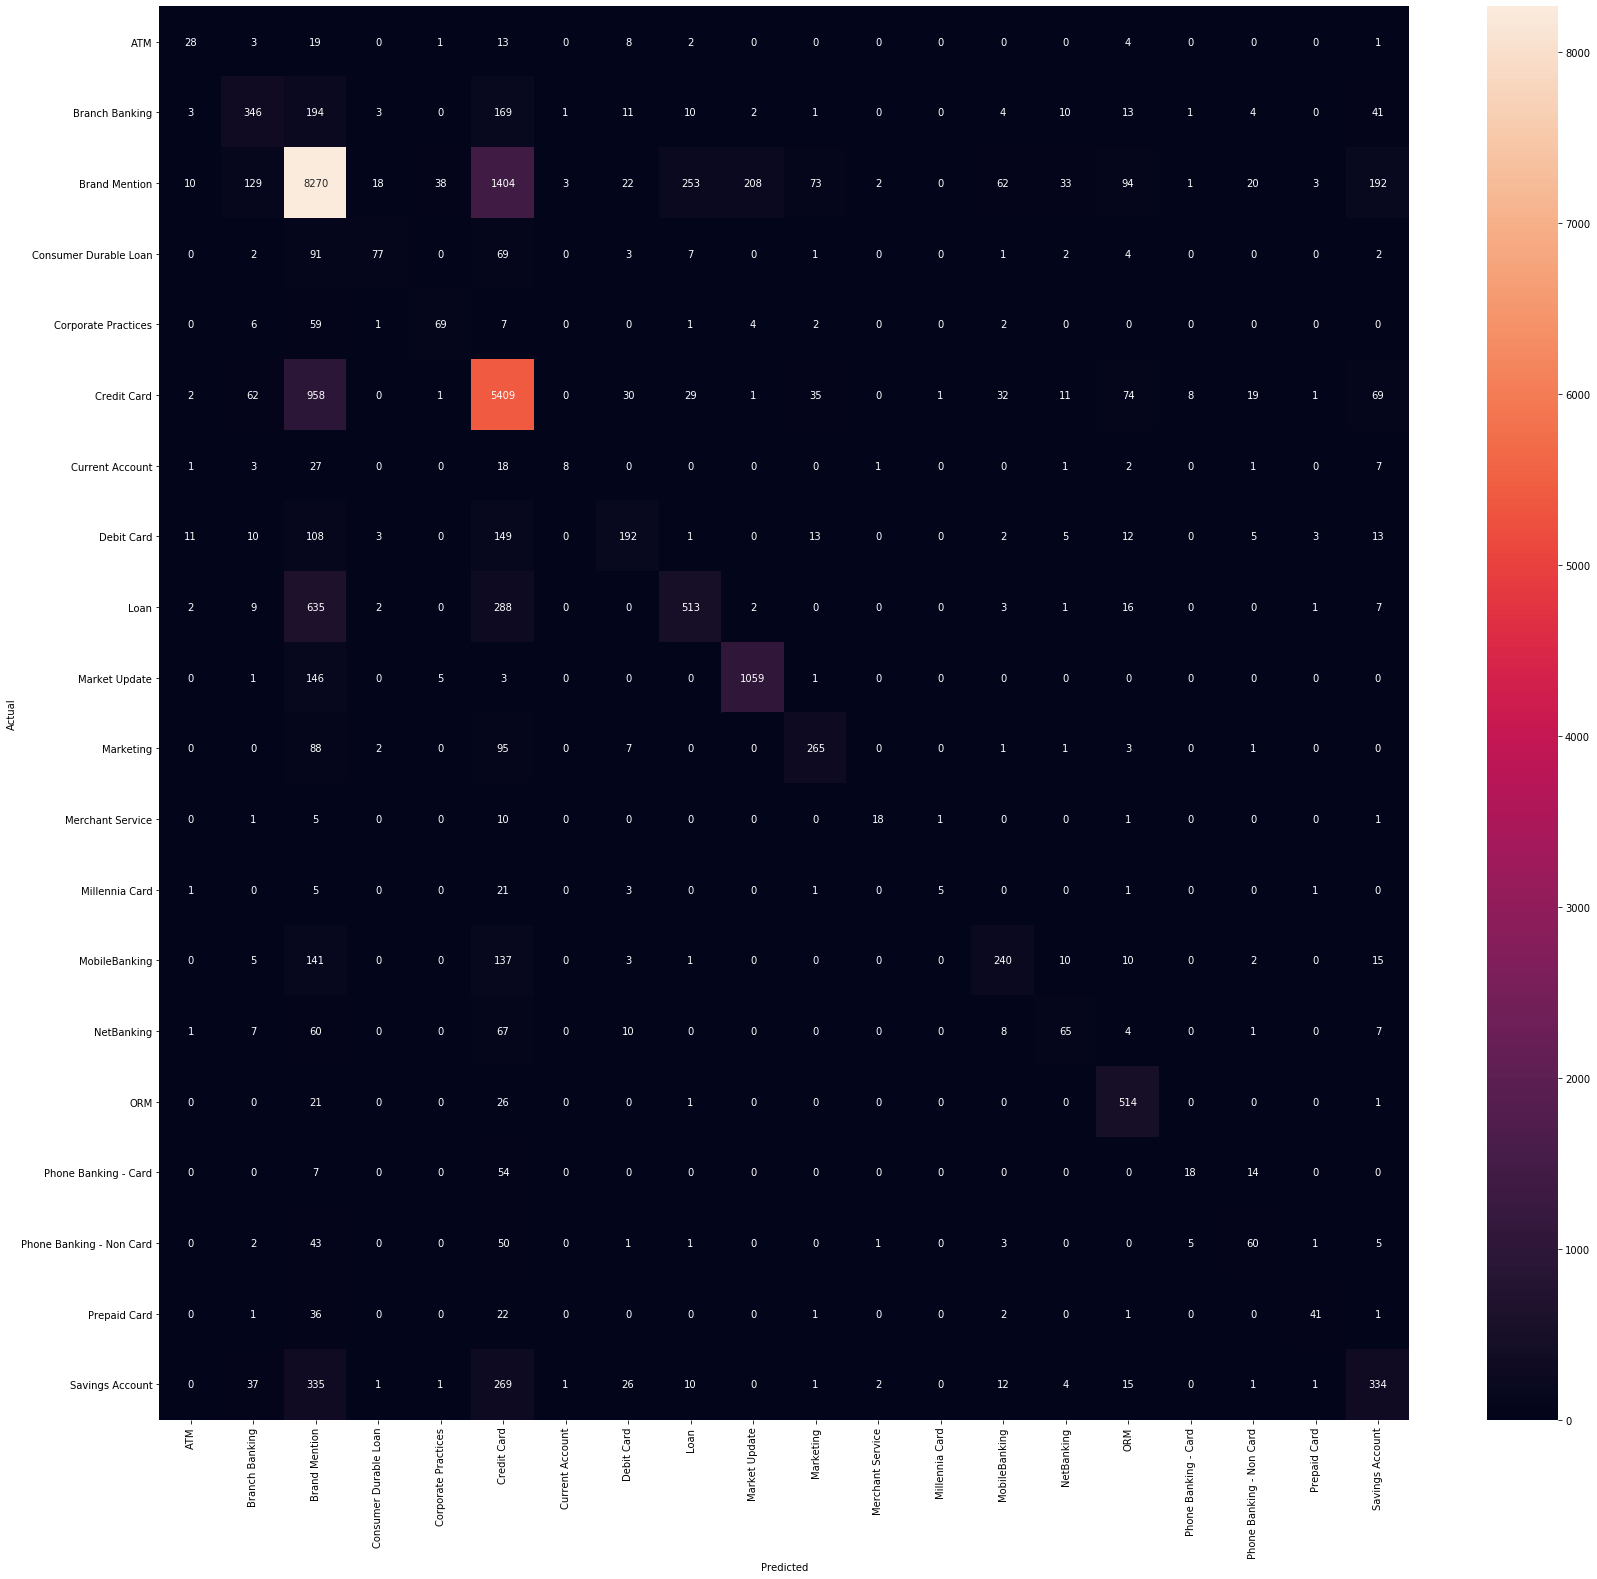

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(Y_test_1, Y_pred_1)
conf_df = pd.DataFrame(conf_mat)
fig, ax = plt.subplots(figsize=(28,26))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=aspect_list, yticklabels=aspect_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [120]:
conf_df.to_csv('/Users/harsha/Downloads/Netscribes/HDFC/lstm_l1_cm_loadedmodel_sd.csv',header=aspect_list)

In [ ]:
json_file = open('/Users/harsha/Downloads/Netscribes/HDFC/lstm_l1_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/harsha/Downloads/Netscribes/HDFC/lstm_l1_model.h5")
print("Loaded model from disk")
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])